In [1]:
!pip install opencv-python ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.1 MB/s eta 0:00:00


Make sure the following folders are correct for you.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
%cd 'Othercomputers/My Computer (1)/EmotionTeller-github'

/content/drive/Othercomputers/My Computer (1)/EmotionTeller-github


We import the metadata and remove the rows of missing files.

In [18]:
import pandas as pd
import ast
import os

data_root       = 'Data' # Folder where all data sources are stored
data_folders    = 'ImageData' # List of folders containing images in .jpg format
data_meta       = ['emotic-relabelled.csv',
                'hgel-relabelled.csv'] # List of metadata corresponding to previous list of folders in .csv format. In our case we relabelled some of the data, so this is different from original metadata.
meta_root       = 'Metadata'

In [19]:
df = pd.read_csv(os.path.join(meta_root,'train_meta.csv'))
df['objects'] = df['objects'].apply(lambda x: ast.literal_eval(x))

# Check if the file exists for each row
df['file_exists'] = df.apply(lambda x: os.path.exists(os.path.join(data_root,data_folders,x.file_name)),axis = 1)

# Drop rows where the file does not exist
df = df[df.file_exists]
df.drop(columns=['file_exists'], inplace=True)

df.head()

,file_name,objects,original_width,original_height,emotions
0,2w4w14gc7v0zzlo2hr.jpg,"{'bbox': [[53.203433030794265, 17.615104049146...",300,361,['Sad']
1,30nuw6i66lmickmbly.jpg,"{'bbox': [[26.798646725660358, 15.553243651943...",500,489,['Sad']
2,6ypnlgwpdwm4cxhzyq.jpg,"{'bbox': [[39.807704879496356, 5.2996237628844...",393,233,['Disgust']
3,7yfw4gdcdak0kdvqu2.jpg,"{'bbox': [[47.60784313725491, 6.43835340508561...",184,274,['Sad']
4,9uq1l58tusi8vij6ju.jpg,"{'bbox': [[38.745098039215634, 17.137253719272...",200,300,['Sad']


In [20]:
import cv2
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


Basic train test split, with no regards for balancing or anything.

In [23]:
!pip install iterative-stratification

In [24]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

In [25]:
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np

df['emotions'] = df['objects'].apply(lambda x: x['categories'])

mlb = MultiLabelBinarizer()

X = df[['file_name']]
y = mlb.fit_transform(df['emotions'])

mss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
idx = np.arange(len(df))

(train_idx, test_idx), = mss.split(idx, y)

train_df = df.iloc[train_idx].reset_index(drop=True)
val_df  = df.iloc[test_idx].reset_index(drop=True)

The emotions to be detected by the model.

In [26]:
emo_dic = {'Neutral':0,'Happy':1,'Surprise':2,'Sad':3,'Angry':4,'Fear':5,'Disgust':6}

The following two cells, create new folders with labels and pictures for our training and validation sets according the structure required by `YOLO`.

In [39]:
yolo_dir = 'YOLO_training'
os.makedirs(yolo_dir, exist_ok=True)

source = 'Human-Group-Emotions-Labelled/'

def xywh2xcycwh(x,y,w,h):
  return [x + w/2, y + h/2, w/2, h/2]

def label(item):
  objs = item['objects']
  text_label = ''
  for ind, emotion in enumerate(objs['categories']):
    x,y,w,h = np.array(objs['bbox'][ind])/100 # Unpack the list into four variables
    xc,yc,wc,hc = xywh2xcycwh(x,y,w,h) # Pass the four variables to the function
    text_label += f'{emo_dic[emotion]} {xc} {yc} {wc} {hc}\n'
  return text_label

In [40]:
import shutil

# Create directories for train and validation images and labels
os.makedirs(os.path.join(yolo_dir,'images','train'), exist_ok=True)
os.makedirs(os.path.join(yolo_dir,'labels','train'), exist_ok=True)
os.makedirs(os.path.join(yolo_dir,'images','val'), exist_ok=True)
os.makedirs(os.path.join(yolo_dir,'labels','val'), exist_ok=True)

# Generate labels and copy images for the training set
for index, row in train_df.iterrows():
    image_name = row['file_name']
    label_content = label(row)
    with open(os.path.join(yolo_dir,'labels','train',image_name.replace('.jpg', '.txt')), 'w') as f:
        f.write(label_content)
    shutil.copy(os.path.join(data_root,data_folders,image_name), os.path.join(yolo_dir,'images','train',image_name))

# Generate labels and copy images for the validation set
for index, row in val_df.iterrows():
    image_name = row['file_name']
    label_content = label(row) # FIX THIS
    with open(os.path.join(yolo_dir,'labels','val',image_name.replace('.jpg', '.txt')), 'w') as f:
        f.write(label_content)
    shutil.copy(os.path.join(data_root,data_folders,image_name), os.path.join(yolo_dir,'images/val/',image_name))

print("Generated label files and copied images for train and validation sets.")

Generated label files and copied images for train and validation sets.


Make sure `data.yaml` is in the `ds_folder`, this contains the structure for the train/val pictures and labels.

In [51]:
model = YOLO('yolo11n.pt')

results = model.train(data = os.path.join(yolo_dir,'data.yaml'), project= os.path.join(yolo_dir), imgsz=1024, epochs = 300,device=0, rect= True)

Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=YOLO_training/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=300, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True,

We use our model to predict on train and validation sets. Make sure you select the correct weights for the latest run.

In [56]:
fine_tuned = YOLO('YOLO_training/train/weights/best.pt')

val_df['path_to_img'] = val_df.apply(lambda x: os.path.join(yolo_dir,'images','val',x.file_name),axis=1)

train_df['path_to_img'] = train_df.apply(lambda x: os.path.join(yolo_dir,'images','train',x.file_name),axis=1)

train_preds = fine_tuned.predict(list(train_df['path_to_img']))
val_preds = fine_tuned.predict(list(val_df['path_to_img']))


0: 1024x1024 (no detections), 1.4ms
1: 1024x1024 (no detections), 1.4ms
2: 1024x1024 (no detections), 1.4ms
3: 1024x1024 (no detections), 1.4ms
4: 1024x1024 (no detections), 1.4ms
5: 1024x1024 1 Sad, 1.4ms
6: 1024x1024 1 Angry, 1.4ms
7: 1024x1024 1 Neutral, 1 Angry, 1.4ms
8: 1024x1024 2 Neutrals, 1.4ms
9: 1024x1024 (no detections), 1.4ms
10: 1024x1024 1 Angry, 1.4ms
11: 1024x1024 1 Angry, 1.4ms
12: 1024x1024 1 Disgust, 1.4ms
13: 1024x1024 1 Happy, 1.4ms
14: 1024x1024 1 Angry, 1.4ms
15: 1024x1024 2 Angrys, 1.4ms
16: 1024x1024 (no detections), 1.4ms
17: 1024x1024 1 Angry, 1.4ms
18: 1024x1024 1 Angry, 1.4ms
19: 1024x1024 1 Sad, 1.4ms
20: 1024x1024 1 Sad, 1.4ms
21: 1024x1024 (no detections), 1.4ms
22: 1024x1024 1 Angry, 1.4ms
23: 1024x1024 (no detections), 1.4ms
24: 1024x1024 7 Fears, 1.4ms
25: 1024x1024 (no detections), 1.4ms
26: 1024x1024 (no detections), 1.4ms
27: 1024x1024 1 Disgust, 1.4ms
28: 1024x1024 2 Fears, 1.4ms
29: 1024x1024 (no detections), 1.4ms
30: 1024x1024 (no detections),

To see how this compares to original labelling, set `pic_id` to any index in the training dataset and run the cell below it.

In [57]:
pic_id=55

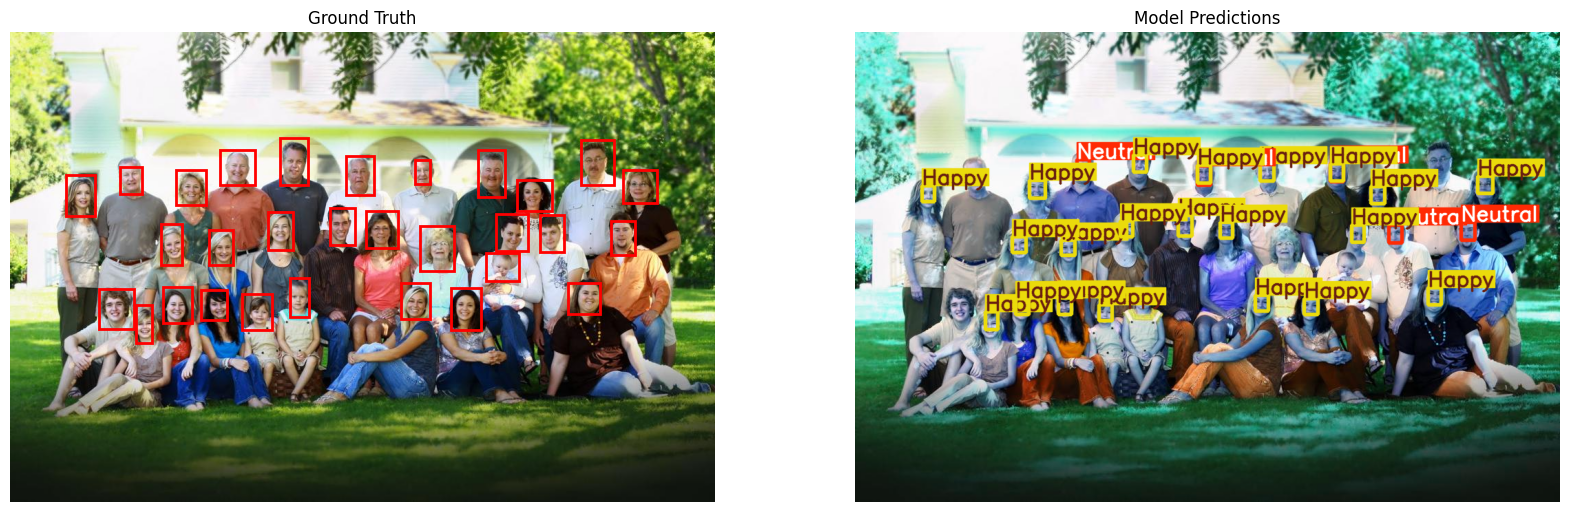

In [58]:
# @title
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

test = train_df.iloc[pic_id]

width = test['original_width']
height = test['original_height']

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Display the original image with ground truth bounding boxes on the left subplot
axes[0].imshow(Image.open(os.path.join(yolo_dir,'images','train',test['file_name'])))
axes[0].set_title('Ground Truth')
axes[0].axis("off")

for bbox in test['objects']['bbox']:
  bbox = np.array(bbox)/100
  x, y, w, h = bbox*[width,height,width,height]

  # Create a Rectangle patch
  rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')

  # Add the patch to the Axes
  axes[0].add_patch(rect)

#Display the image with model predictions on the right subplot
axes[1].imshow(train_preds[pic_id].plot(conf = False, line_width = int(width*0.003))) # YOLO's plot method returns an image
axes[1].set_title('Model Predictions')
axes[1].axis("off")

plt.show()